In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import ExtraTreesClassifier as ExTC
from pprint import pprint
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [2]:
R2 = pd.read_csv('./surrogate_performance/R^2.csv', index_col=0)
features = pd.read_csv('./features/benchmark.csv', index_col=0)

In [3]:
# Drop NANs
features.dropna(axis = 1, inplace=True)

In [4]:
# Drop columns with only one unique value
cols = features.select_dtypes([np.number]).columns
std = features[cols].std()
cols_to_drop = std[std==0].index
features = features.drop(cols_to_drop, axis=1)

In [5]:
# Drop columns with inf
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.dropna(axis = 1, inplace=True)

In [6]:
# Calculating Loss and Targets. Target is the modelling method with lowest loss.
loss = -R2.sub(R2.max(axis=1), axis=0)
targets = loss.idxmin(axis=1)

In [7]:
# Getting data that is avalable in both targets and features
features_available_for = targets.index.intersection(features.index)
targets = targets.loc[features_available_for]

In [8]:
# Train test split
train_features, test_features, train_targets, test_targets = tts(features, targets)

In [9]:
# Training the selector
selector = ExTC()
selector.fit(train_features.values, train_targets.values)

/home/rishi/.virtualenvs/ModelSelector/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [10]:
predicted_targets = selector.predict(test_features)
predicted_targets = pd.DataFrame(predicted_targets, index=test_features.index, columns=['Prediction'])

<IPython.core.display.Javascript object>


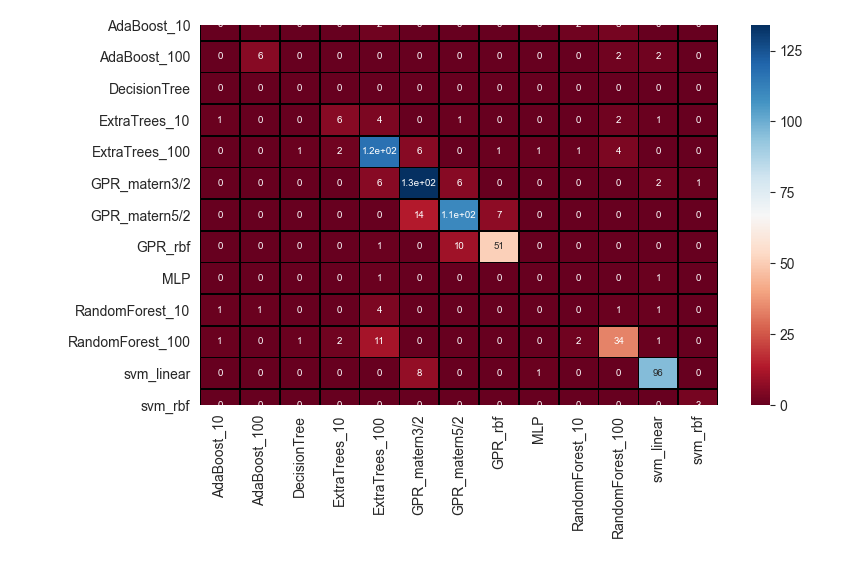

In [11]:
con_mat = metrics.confusion_matrix(test_targets, predicted_targets)
con_mat = pd.DataFrame(con_mat, index=selector.classes_, columns= selector.classes_)
sns.set_style("whitegrid")
sns.heatmap(con_mat,cmap="RdBu",annot=True,annot_kws={"size": 7},linewidths=0.5, linecolor='black')
plt.tight_layout()

In [12]:
# For loss comparison
comparison_index = loss.index.intersection(predicted_targets.index)
loss_compare = loss.loc[comparison_index]
loss_prediction = pd.DataFrame(columns=['Prediction'], index=comparison_index, dtype=float)

In [13]:
for comp_id in comparison_index:
    loss_prediction['Prediction'].at[comp_id] = loss_compare[predicted_targets.loc[comp_id]].loc[comp_id]

In [14]:
loss_compare.sort_index(axis=1, inplace=True)
loss_compare = loss_compare.join(loss_prediction)

<IPython.core.display.Javascript object>


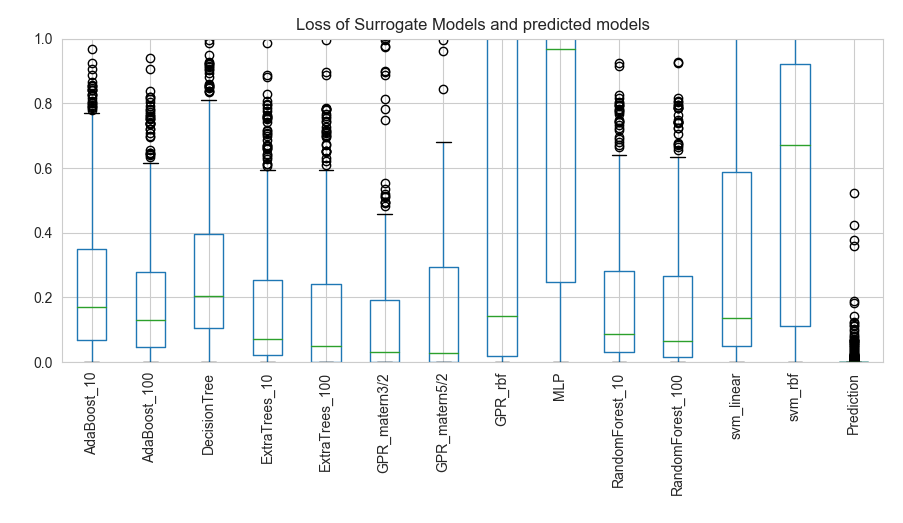

Prediction    0.029825
Name: 0.95, dtype: float64

In [15]:
loss_chart = loss_compare.boxplot(rot=90)
loss_chart.set_title('Loss of Surrogate Models and predicted models')
loss_chart.set_ylim([0,1])
plt.tight_layout()
loss_prediction.quantile(q=0.95)

In [16]:
loss_compare.describe()

,AdaBoost_10,AdaBoost_100,DecisionTree,ExtraTrees_10,ExtraTrees_100,GPR_matern3/2,GPR_matern5/2,GPR_rbf,MLP,RandomForest_10,RandomForest_100,svm_linear,svm_rbf,Prediction
count,678.000000,678.000000,6.780000e+02,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000
mean,0.259470,0.216228,2.988947e-01,0.185836,0.169429,0.726995,1.545235,26.251562,3.766710,0.199454,0.185754,0.337692,0.597663,0.006900
std,0.275446,0.258275,2.870420e-01,0.255288,0.256343,2.691977,6.229350,99.127979,6.102693,0.261518,0.262196,0.423157,0.501186,0.037303
min,-0.000000,-0.000000,8.881784e-16,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
25%,0.069437,0.048109,1.066697e-01,0.023278,0.001458,0.000012,0.000188,0.017621,0.248230,0.031194,0.017045,0.050696,0.111683,-0.000000
50%,0.169392,0.131043,2.054401e-01,0.072212,0.051238,0.032568,0.029089,0.144088,0.967913,0.087277,0.064370,0.137924,0.672596,-0.000000
75%,0.349676,0.278763,3.968508e-01,0.253241,0.242620,0.191918,0.293026,3.183295,4.221211,0.282969,0.265955,0.587027,0.920620,-0.000000
max,1.713249,1.658380,1.639183e+00,1.594604,1.595626,56.835324,58.379966,640.163801,42.903156,1.639989,1.622708,3.666497,2.657132,0.521384


## Feature Importances

In [17]:
importances = selector.feature_importances_
std = np.std([tree.feature_importances_ for tree in selector.estimators_],
             axis=0)
feat_importance = pd.DataFrame(np.vstack((importances, std)), columns=features.columns, index=['mean', 'std'])

/home/rishi/.virtualenvs/ModelSelector/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


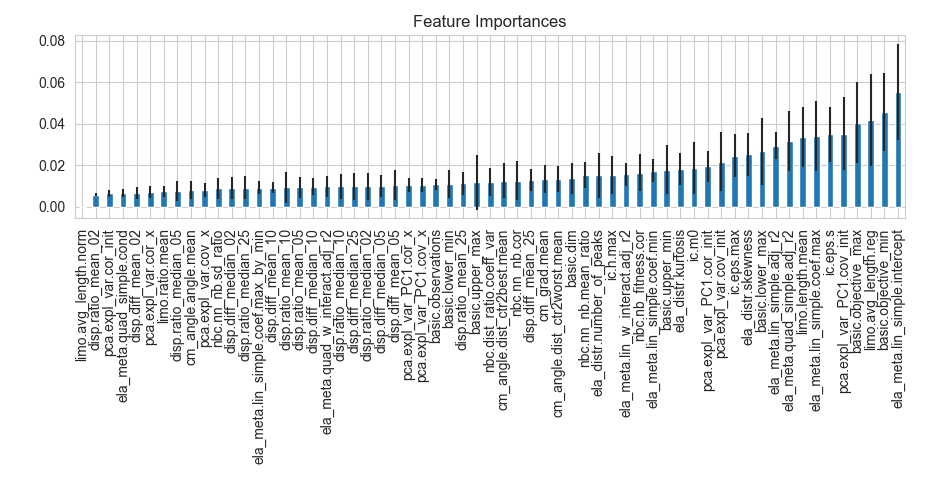

In [18]:
feat_importance.sort_index(by=['mean'], axis=1, inplace=True)
fig = feat_importance.loc['mean'].plot.bar(yerr=feat_importance.loc['std'])
plt.title('Feature Importances')
plt.tight_layout()

In [19]:
engineering_features = pd.read_csv("./features/engineering.csv", index_col=0)
engineering_features = engineering_features[features.columns]
engineering_features = engineering_features.dropna()

In [20]:
engineering_R2 = pd.read_csv('./surrogate_performance/engineeringR^2.csv', index_col=0)
# Calculating Loss and Targets. Target is the modelling method with lowest loss.
engineering_loss = -engineering_R2.sub(engineering_R2.max(axis=1), axis=0)
engineering_targets = engineering_loss.idxmin(axis=1)
# Getting data that is avalable in both targets and features
features_available_for = engineering_targets.index.intersection(engineering_features.index)
engineering_targets = engineering_targets.loc[features_available_for]
engineering_loss = engineering_loss.loc[features_available_for]

<IPython.core.display.Javascript object>


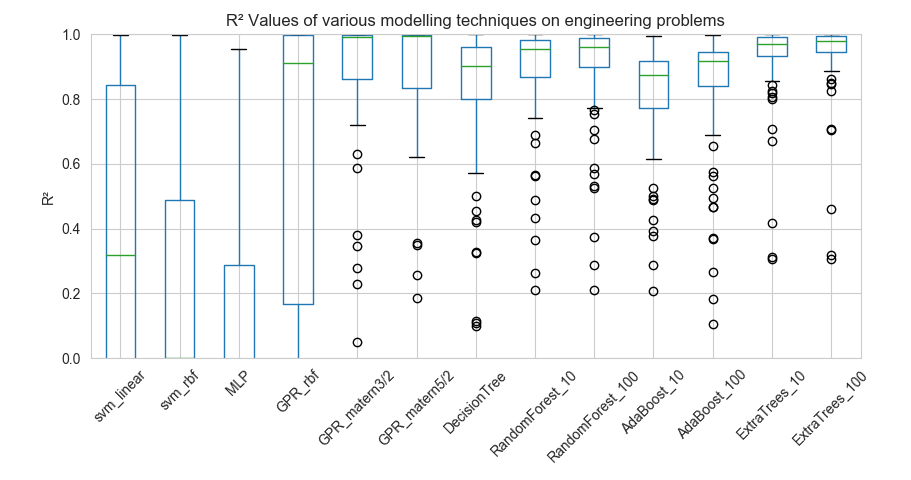

In [21]:
engineering_R2.plot.box(rot=45)
plt.ylim([0,1])
plt.ylabel('R²')
plt.title('R² Values of various modelling techniques on engineering problems')
plt.tight_layout()

In [22]:
selector = ExTC()
selector.fit(features.values, targets.values)
engineering_predictions = selector.predict(engineering_features)
engineering_predictions = pd.DataFrame(engineering_predictions, index=engineering_features.index, columns=['Prediction'])

/home/rishi/.virtualenvs/ModelSelector/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [23]:
metrics.confusion_matrix(engineering_targets, engineering_predictions)

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0, 12,  0,  6,  0,  0, 11,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  0,  4,  0, 16,  2,  0,  0,  2],
       [ 1,  0,  9,  2,  5,  0,  0,  0,  1],
       [ 0,  0,  1,  2,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [24]:
engineering_loss_prediction = pd.DataFrame(columns=['Prediction'], index=engineering_features.index, dtype=float)
for comp_id in engineering_features.index:
    engineering_loss_prediction['Prediction'].at[comp_id] = engineering_loss[engineering_predictions.loc[comp_id]].loc[comp_id]

In [25]:
engineering_loss.sort_index(axis=1, inplace=True)
engineering_loss = engineering_loss.join(engineering_loss_prediction)

## Cross Validation data

In [26]:
cv_scores_mean = pd.read_csv("./surrogate_performance/engineeringCV-score-mean.csv", index_col=0)
cv_scores_mean = cv_scores_mean.loc[features_available_for]
cv_scores_max = pd.read_csv("./surrogate_performance/engineeringCV-score-max.csv", index_col=0)
cv_scores_max = cv_scores_max.loc[features_available_for]

In [27]:
cv_mean_best = cv_scores_mean.idxmax(axis=1)
cv_max_best = cv_scores_max.idxmax(axis=1)

In [28]:
metrics.confusion_matrix(engineering_targets, cv_mean_best)

array([[ 0,  1,  0,  0,  0,  0],
       [ 0, 26,  2,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0],
       [ 0,  1,  2, 20,  3,  0],
       [ 0,  0,  0,  2, 16,  0],
       [ 0,  0,  2,  1,  0,  0]])

In [29]:
metrics.confusion_matrix(engineering_targets, cv_max_best)

array([[ 0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 26,  2,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  3, 22,  1,  0],
       [ 0,  0,  0,  0,  5, 13,  0],
       [ 0,  0,  0,  2,  1,  0,  0]])

In [30]:
engineering_loss_predictionCVmax = pd.DataFrame(columns=['PredictionCVmax'], index=engineering_features.index, dtype=float)
for comp_id in engineering_features.index:
    engineering_loss_predictionCVmax['PredictionCVmax'].at[comp_id] = engineering_loss[cv_max_best.loc[comp_id]].loc[comp_id]

    
    engineering_loss_predictionCVmean = pd.DataFrame(columns=['PredictionCVmean'], index=engineering_features.index, dtype=float)
for comp_id in engineering_features.index:
    engineering_loss_predictionCVmean['PredictionCVmean'].at[comp_id] = engineering_loss[cv_mean_best.loc[comp_id]].loc[comp_id]

In [31]:
engineering_loss = engineering_loss.join(engineering_loss_predictionCVmax)
engineering_loss = engineering_loss.join(engineering_loss_predictionCVmean)

## Plots

<IPython.core.display.Javascript object>


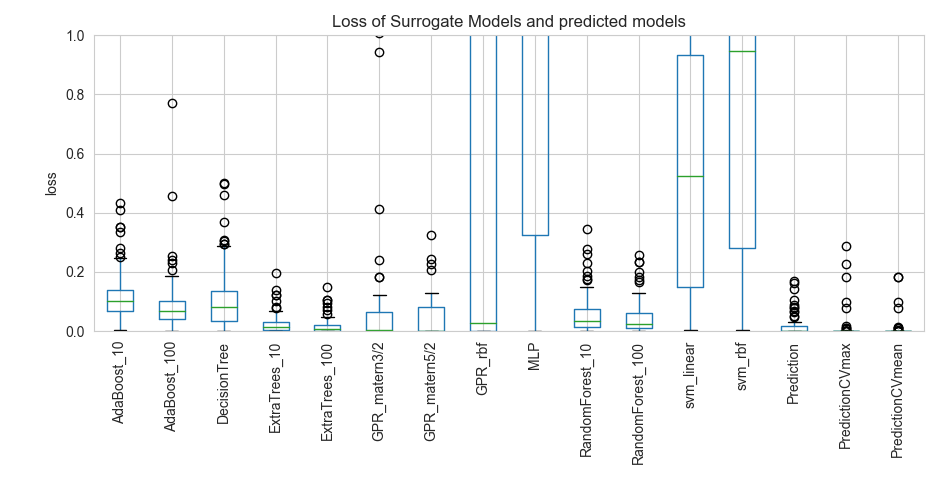

In [32]:
engg_loss_chart = engineering_loss.boxplot(rot=90)
engg_loss_chart.set_title('Loss of Surrogate Models and predicted models')
plt.ylabel('loss')
engg_loss_chart.set_ylim([0,1])
plt.tight_layout()
engg_loss_chart

<IPython.core.display.Javascript object>


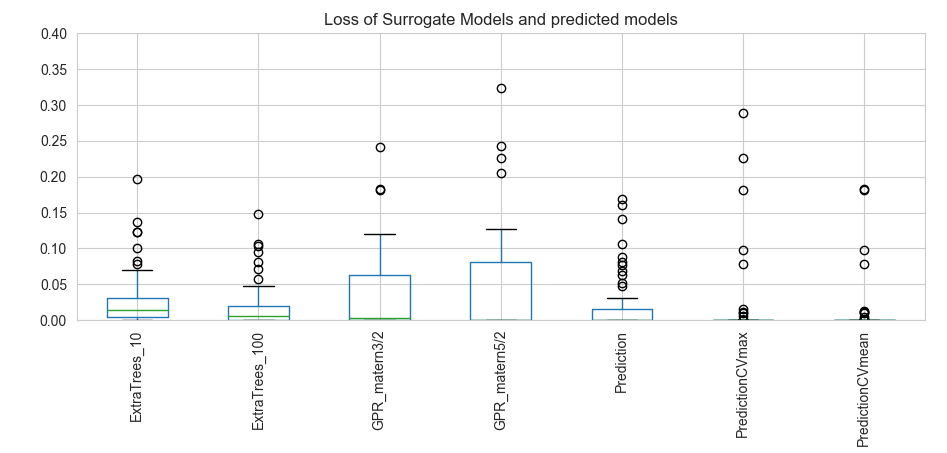

In [33]:
engg_loss_chart = engineering_loss[['ExtraTrees_10','ExtraTrees_100', 'GPR_matern3/2','GPR_matern5/2', 'Prediction', 'PredictionCVmax', 'PredictionCVmean']].boxplot(rot=90)
engg_loss_chart.set_title('Loss of Surrogate Models and predicted models')
engg_loss_chart.set_ylim([0,0.4])
plt.tight_layout()
engg_loss_chart

In [34]:
engineering_loss.describe()

,AdaBoost_10,AdaBoost_100,DecisionTree,ExtraTrees_10,ExtraTrees_100,GPR_matern3/2,GPR_matern5/2,GPR_rbf,MLP,RandomForest_10,RandomForest_100,svm_linear,svm_rbf,Prediction,PredictionCVmax,PredictionCVmean
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,0.119753,0.100426,0.111450,0.026402,0.016720,0.151598,0.176945,32.971680,66.272585,0.058712,0.048652,0.531101,0.703219,0.178571,0.011911,0.007711
std,0.095361,0.152892,0.116977,0.036064,0.028565,0.406823,0.490960,111.351412,220.510202,0.071614,0.060653,0.398577,0.436696,0.746865,0.047667,0.032145
min,0.005125,0.001085,0.000036,-0.000000,-0.000000,0.000002,-0.000000,-0.000000,-0.000000,0.000016,0.000010,0.002114,0.002207,-0.000000,-0.000000,-0.000000
25%,0.067919,0.039794,0.034042,0.003758,-0.000000,0.000107,-0.000000,0.000031,0.323454,0.013309,0.009045,0.149653,0.279390,-0.000000,-0.000000,-0.000000
50%,0.101976,0.067813,0.079759,0.013654,0.005676,0.003260,0.000050,0.028301,3.723865,0.033138,0.024081,0.525263,0.948181,0.000484,-0.000000,-0.000000
75%,0.140208,0.099816,0.136860,0.030999,0.019397,0.063207,0.080757,1.547610,26.708943,0.074922,0.060918,0.932190,1.038348,0.016013,-0.000000,-0.000000
max,0.432549,1.053990,0.501111,0.197298,0.148233,2.214465,2.702947,413.478576,1259.316729,0.345750,0.256170,1.237660,1.306356,5.589715,0.288367,0.183104


In [38]:
engineering_loss.median()

AdaBoost_10         0.101976
AdaBoost_100        0.067813
DecisionTree        0.079759
ExtraTrees_10       0.013654
ExtraTrees_100      0.005676
GPR_matern3/2       0.003260
GPR_matern5/2       0.000050
GPR_rbf             0.028301
MLP                 3.723865
RandomForest_10     0.033138
RandomForest_100    0.024081
svm_linear          0.525263
svm_rbf             0.948181
Prediction          0.000872
PredictionCVmax     0.000000
PredictionCVmean    0.000000
dtype: float64